In [1]:
!pip install importlib-metadata==4.13.0

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [2]:
!pip install dionysus
!pip install gudhi
!pip install networkx
!pip install persim
!pip install xarray
!pip install validclust

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440668 sha256=fe586c1f56965b77a11aff5079ece33299aa31e62942c08f2d8a9a36485b2e65
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18101 sha256=d983fdb9368bc1b0c13fce4029346be0620cfd26dcdb0d55c5faf11b904104a1
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp


In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/My Drive/NASA")
!ls -ltr

total 14447
-rw------- 1 root root    1667 Oct  5  2022  zigzagtools.py
-rw------- 1 root root   85452 Oct  5  2022  zigzag_PD_eps_1.pdf
-rw------- 1 root root       0 Oct  5  2022  VRrips.pk
-rw------- 1 root root  133051 Oct  5  2022  PIs_labelled_modulo_month.pdf
-rw------- 1 root root  132779 Oct  5  2022  PIs_labelled_modulo_month_1.pdf
-rw------- 1 root root  105850 Oct  5  2022  PIs_labelled_modulo_month_0.pdf
-rw------- 1 root root  127787 Oct  5  2022  PIs_labelled_1.pdf
-rw------- 1 root root  116243 Oct  5  2022  PIs_labelled_0.pdf
-rw------- 1 root root  253295 Oct  5  2022  PClouds.pdf
-rw------- 1 root root 1682280 Oct  5  2022  Merra_t2m_freudenthal_Oct_2022.ipynb
-rw------- 1 root root  324306 Oct  5  2022  Merra_t2m_freudenthal.ipynb
-rw------- 1 root root  323836 Oct  5  2022  MERRA2_t2m_GP_20210201-20210228.nc
-rw------- 1 root root 1690684 Oct  5  2022  MERRA2_t2m_CONUS_20210201-20210228.nc
-rw------- 1 root root  527019 Oct  5  2022  MERRA2_t2m_CONUS_20210201-20210

In [6]:
from __future__ import print_function
import numpy as np
from numpy import linalg as LA
import pandas as pd
#import networkx as nx
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import dionysus as d
import matplotlib.pyplot as plt
import numpy as np
import gudhi as gd
import sys
import time
import itertools

In [7]:
!pip install POT==0.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for POT: filename=POT-0.5.1-cp310-cp310-linux_x86_64.whl size=284990 sha256=7752707c458f01b51cbe54fdbccef5825fdd00b28b085ea82338c6fe0c6197b6
  Stored in directory: /root/.cache/pip/wheels/d6/58/ea/7f965a8540b44cd963a1f6c9a5c0554e777eea26f5bb0b5d2d
Successfully built POT


In [8]:
import os
# added
import ot
from gudhi.wasserstein import wasserstein_distance as wd
#import regrid_hp as rhp
#import cartopy.crs as ccrs
#import healpy as hp
import xarray as xr
import mpl_toolkits

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from persim import wasserstein
from sklearn.cluster import DBSCAN


In [30]:
from sklearn.cluster import KMeans

In [9]:
path = os.getcwd()
maxDimHoles = 2 # Maximum Dimension of Holes (It means.. 0 and 1)
sizeWindow = 28 # [Example 2 and 3] Number of Point-Clouds (i.e. timestamps)


In [11]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower =240., infinity = 300.):

    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = infinity
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = infinity

    return [[birth0,death0],[birth1,death1]]

In [12]:
def plot_PDs (pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(25,15))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][:,0], pd0_array[iday][:,1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][:,0], pd1_array[iday][:,1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')

        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        ax.set_xlim([lower_bound, upper_bound])
        ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        #ax.set_xlabel('Birth')
        #ax.set_ylabel('Death')
        #ax.set_xticks(np.arange(4)*20+240)
        #ax.set_xticklabels(np.repeat('',4))
        #ax.set_yticks(np.arange(4)*20+240)
        #ax.set_yticklabels(np.repeat('',4))

In [13]:
def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,20))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5, facecolors='none', edgecolor='blue', label = '1')

        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        ax.set_xlim([lower_bound, upper_bound])
        ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()


In [15]:
fname = 'MERRA2_t2m_GP_20210201-20210228.nc'
ds = xr.open_dataset(fname)
data = ds['t2m'].squeeze()
nday = 28
lon = ds.lon
lat = ds.lat
p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[0,:])

print (data[0,:, :])

<xarray.DataArray 't2m' (y: 41, x: 33)>
[1353 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 2021-06-16
Dimensions without coordinates: y, x


In [21]:
innerSizeWindow=7
lower=int(np.floor(innerSizeWindow/2))
upper=int(np.ceil(innerSizeWindow/2))

In [26]:
#freudenthal_complex = []
pd0 = []
pd1 = []

#freudenthal_complex_union = []
pd0_union = []
pd1_union = []
for iday in np.arange(nday):
    # Build freudenthal_triangulation for individual day
    p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[iday,:]) #p0, p1 are list of two arrays
    #freudenthal_complex.append(cc)
    pd0.append(p0)
    pd1.append(p1)
    # Build freudenthal_triangulation for the union of two consecutive days
    #if iday != nday-1:
    #p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(0.5*data[iday,:]+0.5*data[iday+1,:])
    p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[iday,:])

    #freudenthal_complex_union.append(cc)
    pd0_union.append(p0)
    pd1_union.append(p1)

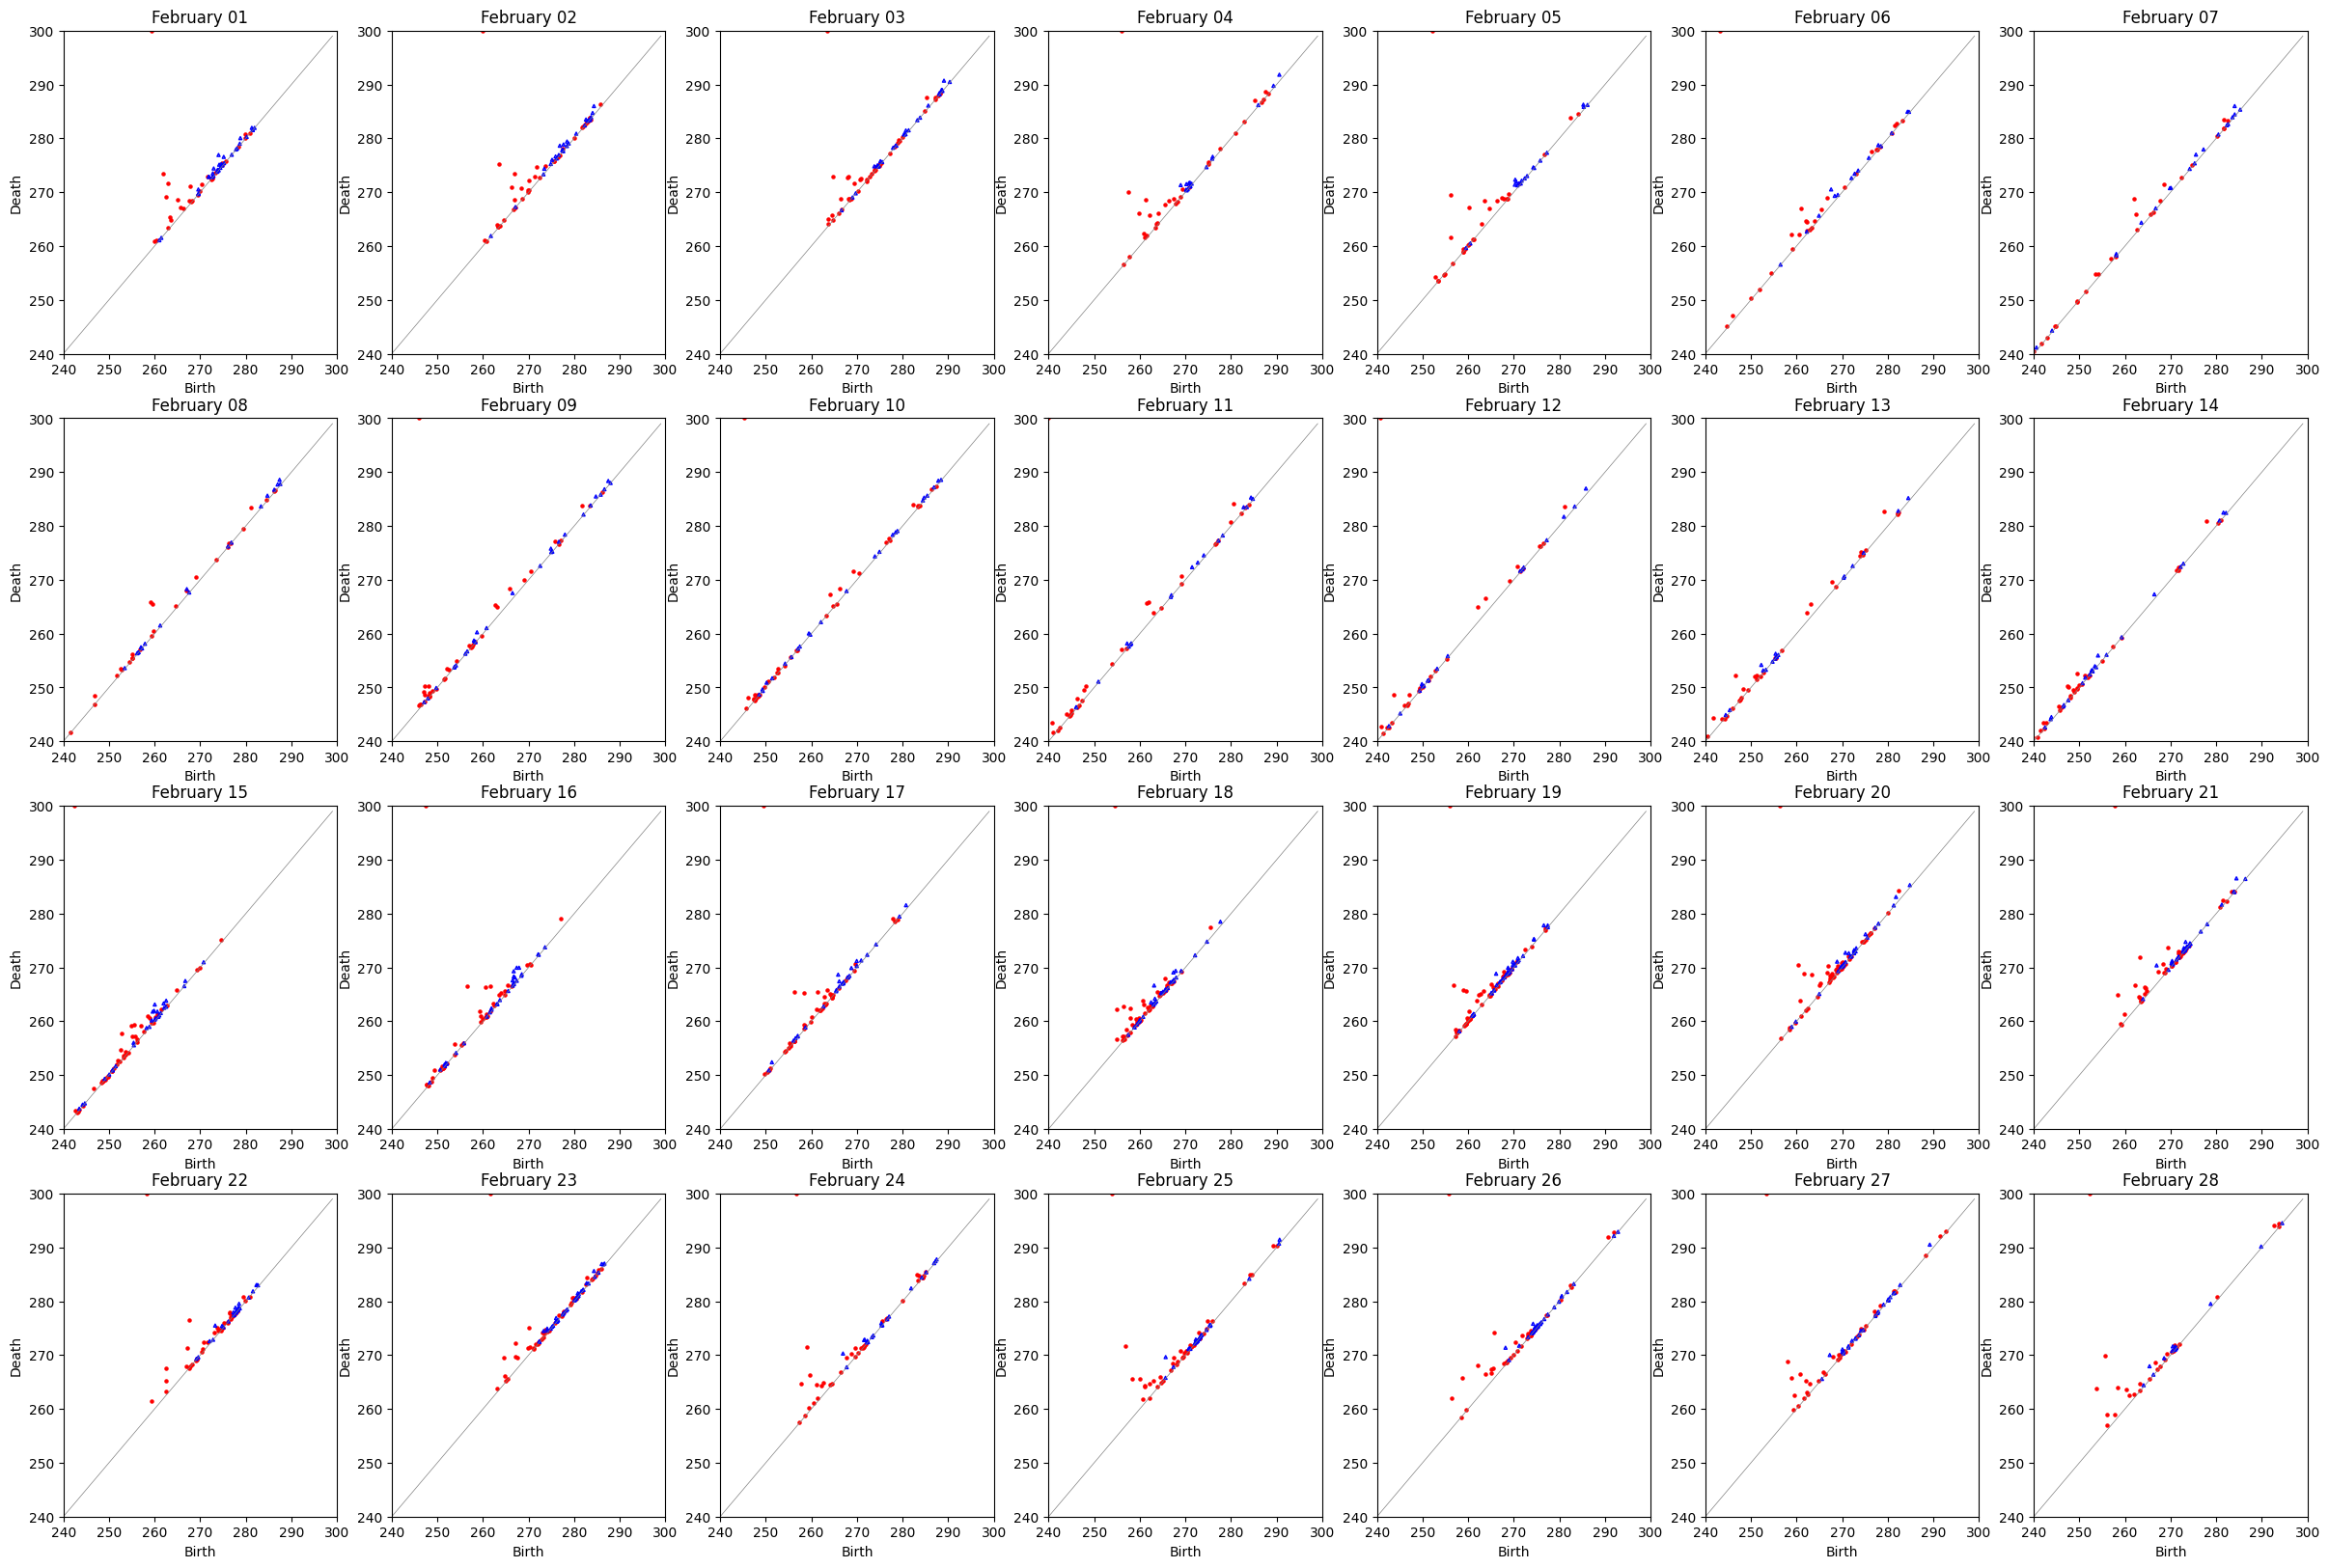

In [27]:
titles = ['February %02d' %(iday+1) for iday in np.arange(nday)]
plot_Dionysus_PDs(pd0_union, pd1_union, titles)

In [29]:
wdist = np.zeros((nday,nday))
for i in range(nday):
    xs= np.concatenate((pd0[i][0][:], pd1[i][0][:]), axis=0)
    ys= np.concatenate((pd0[i][1][:], pd1[i][1][:]), axis=0)
    Di = np.transpose([xs,ys])

    for j in range(i+1):
        #print(i,j)
        xs= np.concatenate((pd0[j][0][:], pd1[j][0][:]), axis=0)
        ys= np.concatenate((pd0[j][1][:], pd1[j][1][:]), axis=0)
        Dj = np.transpose([xs,ys])

        wdist[i,j] = wd(Di, Dj, order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
        wdist[j,i] = wdist[i,j]

wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [31]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(wdist)
kmeans.labels_

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [28]:
groundTruth=np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
      0, 0, 0, 0, 0, 0, 0], dtype='float64')